In [3]:
import os
import sys
import time
import json
import shutil 
import argparse
import numpy as np
from math import e, log, exp, expm1
import matplotlib
import matplotlib.pyplot as plt
from math import e, log
import scipy.stats
import scipy.signal
from PIL import Image, ImageDraw
import pandas as pd

import tensorflow as tf

import cv2

from ggplot import *

from IPython import display

from pymongo import MongoClient

client = MongoClient()
tocada = client['tocada']
#byframe = tocada['byframe']
byframe = tocada['byframe_obj']


In [41]:
from feature_extractor.feature_extractor import FeatureExtractor
import feature_extractor.utils as utils

tf.reset_default_graph()

feat_layer2extract = 'global_pool'
feat_networkname = 'resnet_v2_50'
#feat_networkname = 'inception_v4'
#feat_networkname = 'vgg_19'
#feat_networkname = 'mobilenet_v1'
#feat_layer2extract = 'Logits'
tf_feat_ext = FeatureExtractor(
    network_name=feat_networkname,
    #checkpoint_path='./cfg/inception_v4.ckpt',
    #checkpoint_path='./cfg/vgg_19.ckpt',
    checkpoint_path='./cfg/resnet_v2_50.ckpt',
    #checkpoint_path='./cfg/mobilenet_v1_1.0_224_frozen.pb',
    batch_size=1,
    num_classes=1001,
    preproc_func_name='inception',
    preproc_threads=2)  

tf_feat_ext.print_network_summary()

def extract_dnn_feat(img_filename):
    tf_feat_ext.enqueue_image_files(img_filename)
    tf_feat=tf_feat_ext.feed_forward_batch([feat_layer2extract])
    dnn_feat = np.array(tf_feat[feat_layer2extract][0], dtype=np.float64).tolist()
    return dnn_feat

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./cfg/resnet_v2_50.ckpt
resnet_v2_50/conv1 has shape (?, 112, 112, 64)
resnet_v2_50/block1/unit_1/bottleneck_v2/shortcut has shape (?, 56, 56, 256)
resnet_v2_50/block1/unit_1/bottleneck_v2/conv1 has shape (?, 56, 56, 64)
resnet_v2_50/block1/unit_1/bottleneck_v2/conv2 has shape (?, 56, 56, 64)
resnet_v2_50/block1/unit_1/bottleneck_v2/conv3 has shape (?, 56, 56, 256)
resnet_v2_50/block1/unit_1/bottleneck_v2 has shape (?, 56, 56, 256)
resnet_v2_50/block1/unit_2/bottleneck_v2/conv1 has shape (?, 56, 56, 64)
resnet_v2_50/block1/unit_2/bottleneck_v2/conv2 has shape (?, 56, 56, 64)
resnet_v2_50/block1/unit_2/bottleneck_v2/conv3 has shape (?, 56, 56, 256)
resnet_v2_50/block1/unit_2/bottleneck_v2 has shape (?, 56, 56, 256)
resnet_v2_50/block1/unit_3/bottleneck_v2/conv1 has shape (?, 56, 56, 64)
resnet_v2_50/block1/unit_3/bottleneck_v2/conv2 has shape (?, 28, 28, 64)
resnet_v2_50/block1/unit_3/bottleneck_v

In [13]:
def get_df(mov_id, cam_id, start_frame=0):
    fname = mov_id + cam_id + "CutH264"
    df = byframe.find({'video_file_name':fname, 'frame_number':{'$gte':start_frame}}) 
    df = list(df)
    return df

def video_to_frames(video_filename, frame_ids=None):
    """Extract frames from video"""
    cap = cv2.VideoCapture(video_filename)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    frames = []
    if cap.isOpened() and video_length > 0:
        #frame_ids = [0]
        count = 0
        success, image = cap.read()
        while success:
            if frame_ids:
                if count in frame_ids:
                    frames.append(image)
                    frame_ids.remove(count)
                    #print("cool", count, frame_ids)
                success, image = cap.read()
                #print(count, frame_ids)
                count += 1
            else:
                break
    return frames

def label_frame(mov, cam, f):

    video_fname = "/media/grj/Data/Work/IRIT/DATA/corpus-irit/F_CutH264/"+mov +"/"+ mov + cam + "CutH264" + ".mp4"
    #print(video_fname)
    frame = video_to_frames(video_fname, frame_ids=[f])
    #print(frame)
    img = Image.fromarray(frame[0][:,:,::-1], 'RGB')
    
    draw = ImageDraw.Draw(img, "RGBA")

    data = byframe.find({'video_file_name':'F1C2CutH264', 'frame_number':int(f)}) 
    data = list(data)[0]
    #print(ind, fra_id)
    #print(data)

    for i, obj in enumerate(data['frame_objects']):
        bbox = obj['bounding_box']['coordinates']
        tl, br = bbox[0], bbox[2]
        draw.rectangle(( tl[0], tl[1], br[0],br[1] ), outline="red")
        draw.text((br[0], br[1]), str(i))
   
    img.save("test.jpg", "JPEG")
    plt.imshow(img)
    plt.show()
    
def show_object(id_obj):
    mov = id_obj.split("_")[0]
    cam = id_obj.split("_")[1]
    fra = id_obj.split("_")[2]
    obj = id_obj.split("_")[3]
    cat = id_obj.split("_")[4]
  
    video_fname = "/media/grj/Data/Work/IRIT/DATA/corpus-irit/F_CutH264/"+mov +"/"+ mov + cam + "CutH264" + ".mp4"
    #print(video_fname)
    frame = video_to_frames(video_fname, frame_ids=[int(fra)])
    img = Image.fromarray(frame[0][:,:,::-1], 'RGB')

    #data = byframe_obj.find({'video_file_name':fname, 'frame_number':n_frame}) 
    #data = list(data).copy()
    data = byframe.find({'video_file_name':'F1C2CutH264', 'frame_number':int(fra)}) 
    data = list(data)[0]
    #print(ind, fra_id)
    #print(data)
    bbox  = [data['frame_objects'][int(obj)]['bounding_box']['coordinates'][0], 
             data['frame_objects'][int(obj)]['bounding_box']['coordinates'][2]]
    br, tl = bbox[0], bbox[1]
    img_c = img.crop(( tl[0], tl[1], br[0],br[1] ))
    plt.imshow(img_c)
    plt.show()

def get_object(id_obj):
    mov = id_obj.split("_")[0]
    cam = id_obj.split("_")[1]
    fra = id_obj.split("_")[2]
    obj = id_obj.split("_")[3]
    cat = id_obj.split("_")[4]
  
    video_fname = "/media/grj/Data/Work/IRIT/DATA/corpus-irit/F_CutH264/"+mov +"/"+ mov + cam + "CutH264" + ".mp4"
    #print(video_fname)
    frame = video_to_frames(video_fname, frame_ids=[int(fra)])
    img = Image.fromarray(frame[0][:,:,::-1], 'RGB')

    #data = byframe_obj.find({'video_file_name':fname, 'frame_number':n_frame}) 
    #data = list(data).copy()
    data = byframe.find({'video_file_name':'F1C2CutH264', 'frame_number':int(fra)}) 
    data = list(data)[0]
    #print(ind, fra_id)
    #print(data)
    bbox  = [data['frame_objects'][int(obj)]['bounding_box']['coordinates'][0], 
             data['frame_objects'][int(obj)]['bounding_box']['coordinates'][2]]
    br, tl = bbox[0], bbox[1]
    img_c = img.crop(( tl[0], tl[1], br[0],br[1] ))
    return img_c

def get_feat_object(id_obj):
    mov = id_obj.split("_")[0]
    cam = id_obj.split("_")[1]
    fra = id_obj.split("_")[2]
    obj = id_obj.split("_")[3]
    cat = id_obj.split("_")[4]
  
    video_fname = "/media/grj/Data/Work/IRIT/DATA/corpus-irit/F_CutH264/"+mov +"/"+ mov + cam + "CutH264" + ".mp4"
    frame = video_to_frames(video_fname, frame_ids=[int(fra)])
    img = Image.fromarray(frame[0][:,:,::-1], 'RGB')

    data = byframe.find({'video_file_name':'F1C2CutH264', 'frame_number':int(fra)}) 
    data = list(data)[0].copy()

    bbox  = [data['frame_objects'][int(obj)]['bounding_box']['coordinates'][0], 
             data['frame_objects'][int(obj)]['bounding_box']['coordinates'][2]]
    br, tl = bbox[0], bbox[1]
    img_c = img.crop(( tl[0], tl[1], br[0],br[1] ))
    
    img_c.save('object.jpg')
    
    dnn_feat = extract_dnn_feat(['object.jpg'])
    #print('---')
    return dnn_feat


    
def compute_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def distance_gravitycenter(bb1, bb2):
    gc_bb1 = [ (bb1['x2'] + bb1['x1'])/2 , (bb1['y2'] + bb1['y1']) / 2 ]
    gc_bb2 = [ (bb2['x2'] + bb2['x1'])/2 , (bb2['y2'] + bb2['y1']) / 2 ]

    dist_gc = ((gc_bb1[0]-gc_bb2[0])**2 + (gc_bb1[0]-gc_bb2[0])**2)**0.5
    return dist_gc

def compute_ious_bboxes(bboxes1, bboxes2):
    list_ious = []
    for j, bbox_j in enumerate(bboxes1):
        br, tl = bbox_j[0], bbox_j[1]
        bbox_toseek = {'x1':tl[0], 'x2':br[0], 'y1': tl[1], 'y2':br[1]}
        ious = []
        for i, bbox_i in enumerate(bboxes2):
        #bbox_i = bboxes[i]
            bri, tli = bbox_i[0], bbox_i[1]
            bbox_tested = {'x1':tli[0], 'x2':bri[0], 'y1': tli[1], 'y2':bri[1]}
            iou = compute_iou(bbox_toseek, bbox_tested)
            ious.append(iou)
        list_ious.append(ious)
    return list_ious

def euclidean_distance(nodes1, nodes2):
    list_dist2 = []
    for node1 in nodes1:
        node1 = np.asarray(node1)
        dist2 = []
        for node2 in nodes2:
            node2 = np.asarray(node2)
            dist_2 = np.sum((node1 - node2)**2)**0.5
            dist2.append(dist_2)
        list_dist2.append(dist2)
    return list_dist2

def compute_distance_bboxes(bboxes1, bboxes2):
    list_ious = []
    for j, bbox_j in enumerate(bboxes1):
        br, tl = bbox_j[0], bbox_j[1]
        bbox_toseek = {'x1':tl[0], 'x2':br[0], 'y1': tl[1], 'y2':br[1]}
        ious = []
        for i, bbox_i in enumerate(bboxes2):
        #bbox_i = bboxes[i]
            bri, tli = bbox_i[0], bbox_i[1]
            bbox_tested = {'x1':tli[0], 'x2':bri[0], 'y1': tli[1], 'y2':bri[1]}
            iou = distance_gravitycenter(bbox_toseek, bbox_tested)
            ious.append(iou)
        list_ious.append(ious)
    return list_ious

def category_correspondance_matrix(categories1, categories2):
    list_category_correspondance = []
    for categorie1 in categories1:
        categorie1 = np.asarray(categorie1)
        catcorr = []
        for categorie2 in categories2:
            categorie2 = np.asarray(categorie2)
            cat_corr = categorie2 == categorie1
            catcorr.append(cat_corr)
        list_category_correspondance.append(catcorr)
    return list_category_correspondance


def similarity_cosine(nodes1, nodes2):
    list_sim = []
    for node1 in nodes1:
        node1 = np.asarray(node1)
        sims = []
        for node2 in nodes2:
            node2 = np.asarray(node2)
            sim = np.sum(node1*node2)/ np.sqrt(np.sum(node1**2) * np.sum(node2**2)) 
            sims.append(sim)
        list_sim.append(sims)
    return list_sim

def compute_similarity_cosine(nodes1, nodes2):
    list_sims = []
    for node1 in nodes1:
        node1 = np.asarray(node1)
        sims = []
        for node2 in nodes2:
            node2 = np.asarray(node2)
            sim = np.sum(node1*node2)/ np.sqrt(np.sum(node1**2) * np.sum(node2**2)) 
            sims.append(sim)
        list_sims.append(sims)
    return list_sims

def similarity_distance(bb1, bb2, weight=0.5):
    gc1_x, gc1_y = (bb1['x2'] + bb1['x1'])/2 , (bb1['y2'] + bb1['y1']) / 2 
    gc2_x, gc2_y = (bb2['x2'] + bb2['x1'])/2 , (bb2['y2'] + bb2['y1']) / 2 
    w1, h1 = np.abs(bb1['x2'] - bb1['x1']) , np.abs(bb1['y2'] - bb1['y1'])
    w2, h2 = np.abs(bb2['x2'] - bb2['x1']) , np.abs(bb2['y2'] - bb2['y1'])
    beta = ( ((gc2_x-gc1_x)/w1)**2 + ((gc2_y-gc1_y)/h1)**2 )
    sim_dist = np.exp(-weight * beta)
    return sim_dist

def compute_similarity_distance(bboxes1, bboxes2, weight=0.5):
    list_sims = []
    for j, bbox_j in enumerate(bboxes1):
        br, tl = bbox_j[0], bbox_j[1]
        bbox_toseek = {'x1':tl[0], 'x2':br[0], 'y1': tl[1], 'y2':br[1]}
        sims = []
        for i, bbox_i in enumerate(bboxes2):
        #bbox_i = bboxes[i]
            bri, tli = bbox_i[0], bbox_i[1]
            bbox_tested = {'x1':tli[0], 'x2':bri[0], 'y1': tli[1], 'y2':bri[1]}
            sim = similarity_distance(bbox_toseek, bbox_tested, weight)
            sims.append(sim)
        list_sims.append(sims)
    return list_sims

def similarity_shape(bb1, bb2, weight=1.5):
    w1, h1 = np.abs(bb1['x2'] - bb1['x1']) , np.abs(bb1['y2'] - bb1['y1'])
    w2, h2 = np.abs(bb2['x2'] - bb2['x1']) , np.abs(bb2['y2'] - bb2['y1'])
    beta =  np.abs(w1-w2)/(w1+w2)  +  np.abs(h1-h2)/(h1+h2) 
    sim_shape = np.exp(-weight * beta)
    return sim_shape

def compute_similarity_shape(bboxes1, bboxes2, weight=1.5):
    list_sim = []
    for j, bbox_j in enumerate(bboxes1):
        br, tl = bbox_j[0], bbox_j[1]
        bbox_toseek = {'x1':tl[0], 'x2':br[0], 'y1': tl[1], 'y2':br[1]}
        sims = []
        for i, bbox_i in enumerate(bboxes2):
        #bbox_i = bboxes[i]
            bri, tli = bbox_i[0], bbox_i[1]
            bbox_tested = {'x1':tli[0], 'x2':bri[0], 'y1': tli[1], 'y2':bri[1]}
            sim = similarity_shape(bbox_toseek, bbox_tested, weight)
            sims.append(sim)
        list_sim.append(sims)
    return list_sim

In [36]:
mov, cam, s_f = 'F1', 'C2', 0
df_follow = get_df('F1', 'C2', start_frame=s_f)

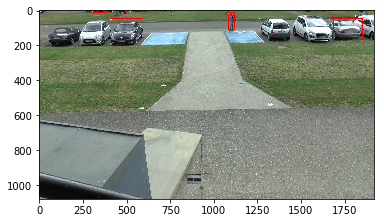

In [16]:
label_frame('F1', 'C2', 1)
#img = get_object('F1_C2_61_5_vehicule')
#img.save("object.jpg", "JPEG")
feat_F1_C2_61_5_v = get_feat_object('F1_C2_61_5_vehicule')

In [53]:
def compute_dnn_feature(mov, cam):
    
    fname = mov + cam + "CutH264"
    #df = byframe.find({'video_file_name':fname, 'frame_number':{'$gte':frame_ind}}) 
    df = get_df(mov, cam, start_frame=0)
    #df = byframe.find({'video_file_name':fname, 'frame_number':{'$gte':frame_ind, '$lte': frame_ind+2}}) 
    #df = list(df)
    l_frames_origin = [ item['frame_number'] for item in df ]
    l_frames = np.sort([ item['frame_number'] for item in df ])
    i_l_frames = np.argsort([ item['frame_number'] for item in df ])
    print(i_l_frames)
    df=[]
    features = []
    for f in l_frames:
        str_ = "frame:"+ str(f) + "/" + str(len(l_frames-1))
        display.clear_output(wait=True)
        display.display(str_)
        
        df = list(byframe.find({'video_file_name':fname, 'frame_number':f}) )[0]
        
        cat_f  = [ item['category'] for item in df['frame_objects'] ]

        labels_f = [mov +'_' + cam +'_' + str(int(f)) +'_' + str(i_n) + '_' +n for i_n, n in enumerate(cat_f) ] 
        
        
        feat_f  = [ get_feat_object(labels_f[n]) for n, item in enumerate(df['frame_objects']) ]    
        features.append(feat_f)
    return features

def compute_distance_graph(mov, cam, start_indexframe=None, b_show=False):
        
    if start_indexframe:
        frame_ind = start_indexframe
    else:
        frame_ind = 0

    fname = mov + cam + "CutH264"
    #df = byframe.find({'video_file_name':fname, 'frame_number':{'$gte':frame_ind}}) 
    df = get_df(mov, cam, start_frame=frame_ind)
    #df = byframe.find({'video_file_name':fname, 'frame_number':{'$gte':frame_ind, '$lte': frame_ind+2}}) 
    #df = list(df)
    l_frames_origin = [ item['frame_number'] for item in df ]
    l_frames = np.sort([ item['frame_number'] for item in df ])
    i_l_frames = np.argsort([ item['frame_number'] for item in df ])
    print(i_l_frames)
    
    df=[]
    

    s_amongframes = []
    d_amongframes = []
    l_amongframes = []
    f_amongframes = []
    t_amongframes = []
    if_amongframes = []
    
    l_eucls = []
    l_gcds = []
    l_ious = []
    l_simdis = []
    l_simsha = []
    l_simcos = []
    
    cat_amongframes = []
    
    for n in range(1):
        i = i_l_frames[n]
        i_1 = i_l_frames[n+1]
        print(i, i_1)

        #print(f, f1)
        f, f1 = l_frames[i], l_frames[i_1]
        print(f, f1)
        
        df = list(byframe.find({'video_file_name':fname, 'frame_number':f}) )[0]
        df1 = list(byframe.find({'video_file_name':fname, 'frame_number':f1}) ) [0]
        
        ifr = int((np.floor(f)-1)/int(float(df['video_frame_rate'])))
        ifr1 = int((np.floor(f1)-1)/int(float(df1['video_frame_rate'])))

        t = df['frame_timestamp']
        t1 = df1['frame_timestamp']
        #print(i, i_1, f, f1, l_frames[i], l_frames[i_1], l_frames_origin[i], l_frames_origin[i_1] )

        mov_f = df['video_file_name'].split("Cut")[0][:2]
        mov_f1 = df['video_file_name'].split("Cut")[0][:2]
        cam_f = df['video_file_name'].split("Cut")[0].split(mov_f)[1]
        cam_f1 = df['video_file_name'].split("Cut")[0].split(mov_f1)[1]

        cat_f  = [ item['category'] for item in df['frame_objects'] ]
        cat_f1  = [ item['category'] for item in df['frame_objects'] ]
        
        labels_f = [mov_f +'_' + cam_f +'_' + str(int(f)) +'_' + str(i_n) + '_' +n for i_n, n in enumerate(cat_f) ] 
        labels_f1 = [mov_f1 +'_' + cam_f1 +'_' + str(int(f1)) + '_' + str(i_n) + '_' +n for i_n, n in enumerate(cat_f1) ] 
        
        print(len(labels_f), len(labels_f1))
        nodes_f  = [ get_feat_object(labels_f[n]) for n, item in enumerate(df['frame_objects']) ]    
        
        print(len(labels_f), len(labels_f1))
        nodes_f1 = [ get_feat_object(labels_f1[n]) for n, item in enumerate(df1['frame_objects']) ]   
           
        #print(np.asarray(nodes_f).shape, np.asarray(nodes_f1).shape)
        bboxes_f  = [ [item['bounding_box']['coordinates'][0], item['bounding_box']['coordinates'][2]] for item in df['frame_objects'] ]          
        bboxes_f1  = [ [item['bounding_box']['coordinates'][0], item['bounding_box']['coordinates'][2]] for item in df1['frame_objects'] ]          
        
        catcorrs = category_correspondance_matrix(cat_f, cat_f1)
        
        ious = np.asarray(compute_ious_bboxes(bboxes_f, bboxes_f1))
        l_ious.append(ious)
        #ious = (ious - np.mean(ious, axis=0)) /  np.std(ious)

        gcds = np.asarray(compute_distance_bboxes(bboxes_f, bboxes_f1))
        l_gcds.append(gcds)
        #gcds = (gcds - np.mean(gcds)) /  np.var(gcds)
        eucls = np.asarray(euclidean_distance(nodes_f, nodes_f1))
        l_eucls.append(eucls)
        #eucls = (eucls - np.mean(eucls)) /  np.var(eucls)
        
        w1 = 0.5
        w2 = 0.5
        sim_dis = np.asarray(compute_similarity_distance(bboxes_f, bboxes_f1, w1))
        l_simdis.append(sim_dis)
        sim_sha = np.asarray(compute_similarity_shape(bboxes_f, bboxes_f1, w2))
        l_simsha.append(sim_sha)
        sim_cos = np.asarray(compute_similarity_cosine(nodes_f, nodes_f1))
        l_simcos.append(sim_cos)
        
        simi = sim_cos * sim_dis * sim_sha #* np.exp(ious-1)
        simi =  simi *  np.asarray(catcorrs)
        
        dist = np.power((np.asarray(eucls)), 2) / (np.asarray(ious)+0.01)
        dist = dist / np.asarray(catcorrs)
        
        d_amongframes.append(dist)
        s_amongframes.append(simi)
        l_amongframes.append([labels_f, labels_f1])
        f_amongframes.append([f, f1])
        t_amongframes.append([t, t1])
        if_amongframes.append([ifr, ifr1])
        #print(_i, i, f, t, ifr)

        cat_amongframes.append(catcorrs)
        #print(nobjs_f, np.argmin(dist, axis=0))
        
    return d_amongframes, l_amongframes, f_amongframes, if_amongframes, t_amongframes, cat_amongframes, s_amongframes


In [ ]:
def follow_object_hungarian(data, ind_startframe = 0, ind_object = 0):
    #from scipy.optimize import linear_sum_assignment
    dists, labels, frames, iframes, timestamps, categories, similarities= compute_distance_graph(data, start_indexframe=ind_startframe)
    objtofollow=ind_object
    s_ind=0
    show_object(data, labels[s_ind][0][objtofollow])
    pathway_objtofollow=[labels[s_ind][0][objtofollow]]
    abnormality_objtofollow=[0]
    martingale_objtofollow=[1]
    M=1
     
    for i, s in enumerate(similarities[:-1]):
        cost = 1-(similarities[i:i+1][0])
        row_ind, col_ind = linear_sum_assignment(cost)
        l_objs = labels[i][0] #np.asarray(data[ind]['frame_objects'])
        l_objs_tolink = labels[i+1][0] #np.asarray(data[ind]['frame_objects'])
        
        if objtofollow in row_ind: 
        #show_object(df_follow, l_objs[objtofollow])
            ind = list(row_ind).index(objtofollow)
            abn = cost[row_ind[ind], col_ind[ind]]
            objtofollow=col_ind[ind]
            eta = 0.92
            xn = abn #np.abs((sim - np.mean(similarity_objtofollow)))
            theta = np.random.uniform(0, 1)

            if len(similarity_objtofollow) == 0:
                p = 0
            else:
                p = ( np.count_nonzero(abnormality_objtofollow > xn) + theta * np.count_nonzero(abnormality_objtofollow==xn) ) / (len(similarity_objtofollow))
            if p > 0:
                M = max(eta* (p**(eta-1)) * M , 1)
            else:
                M = 1
            
            if abn >= 0.99:
                break
            else:
                martingale_objtofollow.append(M)
                pathway_objtofollow.append(l_objs_tolink[objtofollow])
                abnormality_objtofollow.append(abn)
            #show_object(df_follow, l_objs_tolink[objtofollow])
        else:
            #print(i, cost, objtofollow, cost[objtofollow],  col_ind, row_ind )
            break

    return pathway_objtofollow, abnormality_objtofollow, martingale_objtofollow
    #show_object(df_follow, l_objs_tolink[objtofollow])
    #print(row_ind, col_ind, cost[objtofollow], cost[objtofollow, col_ind[objtofollow]])
    #print(l_objs)

In [7]:
np.asarray(dnn_feat).shape


NameError: name 'dnn_feat' is not defined

In [57]:
F1C2_feat = compute_dnn_feature('F1', 'C2')

'frame:42.0/8661'

---
---
---
---
---
---
---


KeyboardInterrupt: 

In [92]:
import tensorflow as tf
import argparse 

# Pass the filename as an argument


    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
with tf.gfile.GFile("./cfg/mobilenet_v1_1.0_224_frozen.pb", "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.global_variables()

    #saver=tf.train.Saver()
    with tf.Graph().as_default() as graph:

        tf.import_graph_def(
            graph_def,
            input_map=None,
            return_elements=None,
            name="prefix",
            op_dict=None,
            producer_op_list=None
        )
        
        sess = tf.Session(graph=graph)
        #saver=tf.train.Saver()
        save_path = saver.save(sess, "./cfg/mobilenet_v1_1.0_224.ckpt")
        print("Model saved to chkp format")

ValueError: No variables to save

In [37]:
export_dir = '/home/grj/GitHub/VICTORIA/cfg/mobilenet/mobile_v1'

with tf.Session(graph=tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, ['mobilenet_v1_1.0_224'], export_dir)

  

    #saver = tf.train.import_meta_graph('/home/grj/GitHub/VICTORIA/cfg/mobilenet/mobile_v1/mobilenet_v1_1.0_224.ckpt.meta')
    
    #saver.restore(sess, save_path = '/home/grj/GitHub/VICTORIA/cfg/mobilenet/mobile_v1/')
        #saver.restore(sess, 'cfg/mobilenet/mobile_v1/mobilenet_v1_1.0_224')
        #saver.restore(sess, "cfg/mobilenet/mobile_v1/")
    #saver = tf.train.Saver(write_version=tf.train.SaverDef.V1)
    #save_path = saver.save(sess, "model.ckpt")

OSError: SavedModel file does not exist at: /home/grj/GitHub/VICTORIA/cfg/mobilenet/mobile_v1/{saved_model.pbtxt|saved_model.pb}

In [7]:
import tensorflow_hub as hub

def image_input_fn(imgs_path):
    filename_queue = tf.train.string_input_producer(
          imgs_path, shuffle=False)
    reader = tf.WholeFileReader()
    _, value = reader.read(filename_queue)
    image_tf = tf.image.decode_jpeg(value, channels=3)
    return tf.image.convert_image_dtype(image_tf, tf.float32)

tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://modeldepot.io/mikeshi/delf')

#file_contents = tf.read_file('./object.jpg')
#image = tf.image.decode_jpeg(file_contents, channels=3)
#image = load_image('object.jpg')
#image_tf = tf.image.convert_image_dtype(image, tf.float32)
#print(image_tf)

image_tf = image_input_fn(['object.jpg'])

image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)



#with tf.train.MonitoredSession() as sess:
#    results_dict = {}  # Stores the locations and their descriptors for each image
#    for image_path in ["object.jpg"]:
#        image = sess.run(image_tf)
#        print('Extracting locations and descriptors from %s' % image_path)
#        results_dict[image_path] = sess.run(
#            [module_outputs['locations'], module_outputs['descriptors']],
#            feed_dict={image_placeholder: image})

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    img = sess.run(image_tf)
    results_dict['object'] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: img})

Tensor("ReaderReadV2:1", shape=(), dtype=string)


In [9]:
def get_delf_features(list_images_path):
    
    image_tf = image_input_fn(['object.jpg'])

    with tf.train.MonitoredSession() as sess:
        results_dict = {}  # Stores the locations and their descriptors for each image
        for image_path in list_images_path:
            image = sess.run(image_tf)
            print('Extracting locations and descriptors from %s' % image_path)
            results_dict[image_path] = sess.run(
                    [module_outputs['locations'], module_outputs['descriptors']],
                    feed_dict={image_placeholder: image})
    #img = sess.run(image_tf)
    #results_dict['object'] = sess.run(
    #        [module_outputs['locations'], module_outputs['descriptors']],
    #        feed_dict={image_placeholder: img})
    #return results_dict
print(img.shape)
print(np.asarray(results_dict['object.jpg'][1]).shape)
print(np.asarray(results_dict['object.jpg'][0]).shape)

Tensor("ReaderReadV2_2:1", shape=(), dtype=string)
Extracting locations and descriptors from object.jpg
(127, 192, 3)
(77, 40)
(77, 2)


In [16]:
from google.protobuf import text_format
from delf import delf_config_pb2
from delf import feature_extractor
from delf import feature_io
config = delf_config_pb2.DelfConfig()
with tf.gfile.FastGFile('/home/grj/Software/models/research/delf/delf/python/examples/delf_config_example.pbtxt', 'r') as f:
    text_format.Merge(f.read(), config)

with tf.Graph().as_default():
    # Reading list of images.
    #filename_queue = tf.train.string_input_producer(, shuffle=False)
    #reader = tf.WholeFileReader()
    #_, value = reader.read(filename_queue)
    image_tf = tf.image.decode_jpeg('object.jpg', channels=3)

    with tf.Session() as sess:
        # Initialize variables.
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

        # Loading model that will be used.
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING],
                                 config.model_path)
        graph = tf.get_default_graph()
        input_image = graph.get_tensor_by_name('input_image:0')
        input_score_threshold = graph.get_tensor_by_name('input_abs_thres:0')
        input_image_scales = graph.get_tensor_by_name('input_scales:0')
        input_max_feature_num = graph.get_tensor_by_name('input_max_feature_num:0')
        boxes = graph.get_tensor_by_name('boxes:0')
        raw_descriptors = graph.get_tensor_by_name('features:0')
        feature_scales = graph.get_tensor_by_name('scales:0')
        attention_with_extra_dim = graph.get_tensor_by_name('scores:0')
        attention = tf.reshape(attention_with_extra_dim,
                             [tf.shape(attention_with_extra_dim)[0]])

        locations, descriptors = feature_extractor.DelfFeaturePostProcessing(
                        boxes, raw_descriptors, config)

OSError: SavedModel file does not exist at: parameters/delf_v1_20171026/model//{saved_model.pbtxt|saved_model.pb}

In [26]:
import tensorflow_hub as hub

def get_delf_features(list_images_path):
    
    def image_input_fn(imgs_path):
        filename_queue = tf.train.string_input_producer(
              imgs_path, shuffle=False)
        reader = tf.WholeFileReader()
        _, value = reader.read(filename_queue)
        image_tf = tf.image.decode_jpeg(value, channels=3)
        return tf.image.convert_image_dtype(image_tf, tf.float32)

    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.FATAL)

    m = hub.Module('https://modeldepot.io/mikeshi/delf')

    image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

    module_inputs = {
        'image': image_placeholder,
        'score_threshold': 100.0,
        'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
        'max_feature_num': 1000,
    }

    module_outputs = m(module_inputs, as_dict=True)

    
    image_tf = image_input_fn(list_images_path)

    with tf.train.MonitoredSession() as sess:
        results_dict = {}  # Stores the locations and their descriptors for each image
        feats, locations = [], []
        for i, image_path in enumerate(list_images_path):
            image = sess.run(image_tf)
            print('Extracting locations and descriptors from %s' % image_path)
            results_dict[image_path] = sess.run(
                    [module_outputs['locations'], module_outputs['descriptors']],
                    feed_dict={image_placeholder: image})
            locations.append(results_dict[image_path][0])
            feats.append(results_dict[image_path][1])
            
    return results_dict, feats, locations



In [44]:
def get_delf_feat_object(id_obj):
    mov = id_obj.split("_")[0]
    cam = id_obj.split("_")[1]
    fra = id_obj.split("_")[2]
    obj = id_obj.split("_")[3]
    cat = id_obj.split("_")[4]
  
    video_fname = "/media/grj/Data/Work/IRIT/DATA/corpus-irit/F_CutH264/"+mov +"/"+ mov + cam + "CutH264" + ".mp4"
    frame = video_to_frames(video_fname, frame_ids=[int(fra)])
    img = Image.fromarray(frame[0][:,:,::-1], 'RGB')

    data = byframe.find({'video_file_name':'F1C2CutH264', 'frame_number':int(fra)}) 
    data = list(data)[0].copy()

    bbox  = [data['frame_objects'][int(obj)]['bounding_box']['coordinates'][0], 
             data['frame_objects'][int(obj)]['bounding_box']['coordinates'][2]]
    br, tl = bbox[0], bbox[1]
    img_c = img.crop(( tl[0], tl[1], br[0],br[1] ))
    
    img_c.save('object.jpg')
    
    delf_feat = get_delf_features(['object.jpg'])
    #print('---')
    return delf_feat


def compute_delf_feature(mov, cam):
    
    fname = mov + cam + "CutH264"
    #df = byframe.find({'video_file_name':fname, 'frame_number':{'$gte':frame_ind}}) 
    df = get_df(mov, cam, start_frame=0)
    #df = byframe.find({'video_file_name':fname, 'frame_number':{'$gte':frame_ind, '$lte': frame_ind+2}}) 
    #df = list(df)
    l_frames_origin = [ item['frame_number'] for item in df ]
    l_frames = np.sort([ item['frame_number'] for item in df ])
    i_l_frames = np.argsort([ item['frame_number'] for item in df ])
    print(i_l_frames)
    df=[]
    features = []
    locations = []
    for f in l_frames[0:2]:
        str_ = "frame:"+ str(f) + "/" + str(len(l_frames-1))
        display.clear_output(wait=True)
        display.display(str_)
        
        df = list(byframe.find({'video_file_name':fname, 'frame_number':f}) )[0]
        
        cat_f  = [ item['category'] for item in df['frame_objects'] ]

        labels_f = [mov +'_' + cam +'_' + str(int(f)) +'_' + str(i_n) + '_' +n for i_n, n in enumerate(cat_f) ] 
        
        objs_path = []
        if not os.path.isdir("/tmp/delf_feat/"):
            os.mkdir('/tmp/delf_feat/') 

        for i_id_obj, id_obj in enumerate(labels_f):
            mov = id_obj.split("_")[0]
            cam = id_obj.split("_")[1]
            fra = id_obj.split("_")[2]
            obj = id_obj.split("_")[3]
            cat = id_obj.split("_")[4]
            video_fname = "/media/grj/Data/Work/IRIT/DATA/corpus-irit/F_CutH264/"+mov +"/"+ mov + cam + "CutH264" + ".mp4"
            frame = video_to_frames(video_fname, frame_ids=[int(fra)])
            img = Image.fromarray(frame[0][:,:,::-1], 'RGB')

            data = byframe.find({'video_file_name':'F1C2CutH264', 'frame_number':int(fra)}) 
            data = list(data)[0].copy()

            bbox  = [data['frame_objects'][int(obj)]['bounding_box']['coordinates'][0], 
                     data['frame_objects'][int(obj)]['bounding_box']['coordinates'][2]]
            br, tl = bbox[0], bbox[1]
            img_c = img.crop(( tl[0], tl[1], br[0],br[1] ))
            imgname = '/tmp/delf_feat/'+str(id_obj)+'.jpg'
            img_c.save(imgname)
            objs_path.append(imgname)
        #print(objs_path)
        dict_feat_f, feat_f, loc_f = get_delf_features(objs_path)
        #print(dict_feat_f)
        #feat_f = dict_feat_f[:][0]
        #feat_f  = [ get_delf_feat_object(labels_f[n]) for n, item in enumerate(df['frame_objects']) ]    
        features.append(feat_f)
        locations.append(loc_f)
        shutil.rmtree('/tmp/delf_feat/')
    return features, locations


In [45]:
delf_F1C2, delf_loc_F1C2 = compute_delf_feature('F1', 'C2')

'frame:2.0/8661'

Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_0_person.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_1_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_2_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_3_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_4_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_5_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_6_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_7_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_8_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_9_vehicule.jpg
Extracting locations and descriptors from /tmp/delf_feat/F1_C2_2_10_vehicule.jpg


In [76]:
for i_, i in enumerate(delf_F1C2):
    for j_, j in enumerate(delf_F1C2[i_]):
        print(j.shape)
        #for k_, k in enumerate(delf_F1C2[i_][j_]):
            


(12, 40)
(6, 40)
(15, 40)
(14, 40)
(5, 40)
(61, 40)
(95, 40)
(65, 40)
(43, 40)
(70, 40)
(62, 40)
(64, 40)
(16, 40)
(6, 40)
(15, 40)
(5, 40)
(67, 40)
(94, 40)
(69, 40)
(37, 40)
(71, 40)
(62, 40)
(68, 40)


NameError: name 'objs_path' is not defined

In [87]:
import ffmpeg
in_file = ffmpeg.input('/media/grj/Data/Work/IRIT/DATA/corpus-irit/F1C2CutH264.mp4')
(ffmpeg
    .in_file.trim(start_frame=10, end_frame=20)
    .output('imagetest.jpg')
    .run()
)

AttributeError: module 'ffmpeg' has no attribute 'in_file'

In [109]:
stream = ffmpeg.input('/media/grj/Data/Work/IRIT/DATA/corpus-irit/F1C2CutH264.mp4')
stream = ffmpeg.filter_(stream, filter_name='select', select='gte(n\, 150)')
stream = ffmpeg.output(stream, '/media/grj/Data/Work/IRIT/DATA/corpus-irit/output.jpg', "vframes 1" )
ffmpeg.run(stream)

img = Image.open("/media/grj/Data/Work/IRIT/DATA/corpus-irit/output.jpg")
plt.imshow(img)
plt.show()

TypeError: output() takes 2 positional arguments but 3 were given

In [139]:
from ffmpy import FFmpeg
ff = FFmpeg(
    inputs={'/media/grj/Data/Work/IRIT/DATA/corpus-irit/F1C2CutH264.mp4': None},
    outputs={'/media/grj/Data/Work/IRIT/DATA/corpus-irit/output.jpg': "-vf 'select=gte(n\, 150)' -vframes 1"} 
        )
print(ff.cmd)
ff.run()

ffmpeg -i /media/grj/Data/Work/IRIT/DATA/corpus-irit/F1C2CutH264.mp4 -vf "select=gte(n\, 150)" -vframes 1 /media/grj/Data/Work/IRIT/DATA/corpus-irit/output.jpg


(None, None)

In [169]:
frame_ids = 150
select_ = "-vf \'select=gte(n\\," + str(frame_ids)+ ")\' -vframes 1"
print(select_)

-vf 'select=gte(n\,150)' -vframes 1


In [171]:
ff = FFmpeg(
    inputs={'/media/grj/Data/Work/IRIT/DATA/corpus-irit/F1C2CutH264.mp4': None},
    outputs={'/media/grj/Data/Work/IRIT/DATA/corpus-irit/output.jpg': select_} 
        )
print(ff.cmd)
ff.run()


ffmpeg -i /media/grj/Data/Work/IRIT/DATA/corpus-irit/F1C2CutH264.mp4 -vf select=gte(n\,150) -vframes 1 /media/grj/Data/Work/IRIT/DATA/corpus-irit/output.jpg


(None, None)

In [ ]:
list_movcam = ["F1C1", "F1C13", "F1C17", "F1C20", "F1C24", "F1C5", 
               "F1C9", "F2C12", "F2C16", "F2C2", "F2C23", "F2C4", "F2C8, "F1C10", "F1C14", "F1C18", "F1C21", "F1C25", "F1C6", "F2C1", "F2C13", "F2C17", "F2C20", "F2C24", "F2C5", "F2C9", "F1C11", "F1C15", "F1C19", "F1C22", "F1C3", "F1C7", "F2C10", "F2C14", "F2C18", "F2C21", "F2C25", "F2C6", "F1C12", "F1C16", "F1C2", "F1C23", "F1C4", "F1C8", "F2C11", "F2C15", "F2C19", "F2C22", "F2C3", "F2C7"])